### Step 0: Load The Data

In [1]:
# Load pickled data
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import pickle
import numpy as np
import tensorflow as tf
import os
import cv2
from scipy import ndimage, misc
"""
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
"""

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 412565993939059277
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11313741824
locality {
  bus_id: 1
}
incarnation: 11283582121181554923
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"
]



### Step 1: Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:

* 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
* 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
* 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
* 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES
Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the pandas shape method might be useful for calculating some of the summary results.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

print(n_train , n_validation, n_test)

image_shape = np.shape(X_train[0])
print(np.shape(X_train))
print(image_shape)
n_classes = len(np.unique(y_train))

EPOCHS = 40
BATCH_SIZE = 129

34799 4410 12630
(34799, 32, 32, 3)
(32, 32, 3)


#### Converting the images to Grayscale and normalizing

In [3]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include
### converting to grayscale, etc.
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_train_normalized = (X_train_gray - np.float32(128))/np.float32(128)

X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)
X_valid_normalized = (X_valid_gray - np.float32(128))/np.float32(128)

X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)
X_test_normalized = (X_test_gray - np.float32(128))/np.float32(128)

print(len(X_valid), len(X_test))

4410 12630


#### Visualizing the images before and after normalization

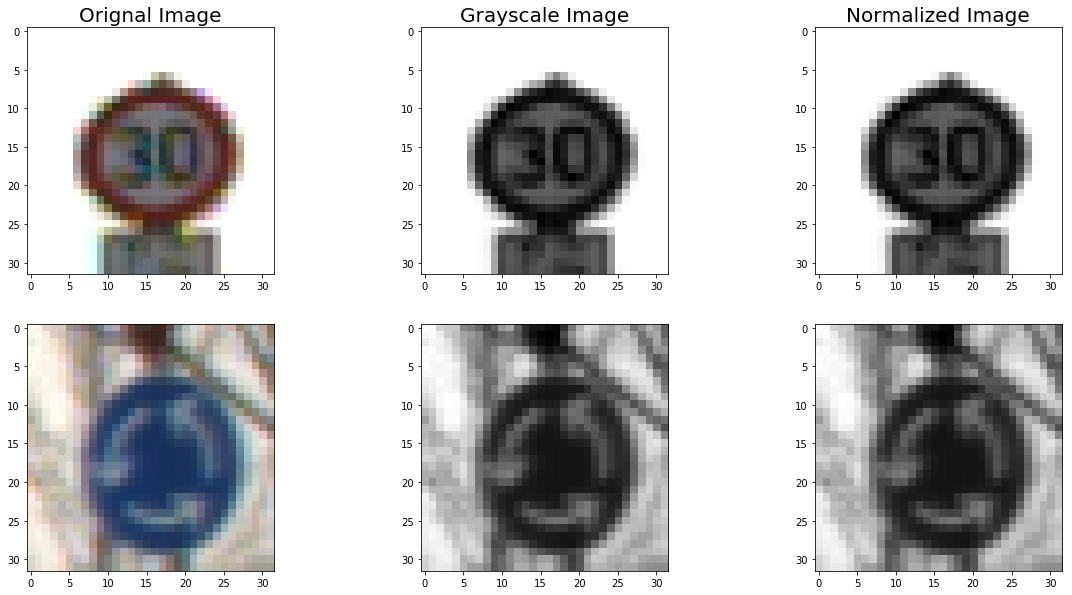

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

fig, axs = plt.subplots(2,3,figsize=(20,10))
axs[0][0].set_title('Orignal Image', fontsize=20)
axs[0][1].set_title('Grayscale Image', fontsize=20)
axs[0][2].set_title('Normalized Image', fontsize=20)
axs[0][0].imshow(X_train[2341])
axs[1][0].imshow(X_train[4354])
axs[0][1].imshow(X_train_gray[2341].squeeze() , cmap='gray')
axs[1][1].imshow(X_train_gray[4354].squeeze() , cmap='gray')
axs[0][2].imshow(X_train_normalized[2341].squeeze() , cmap='gray')
axs[1][2].imshow(X_train_normalized[4354].squeeze() , cmap='gray')

#### Check the image distribution by distributing the images to distinct containers. There are in total 43 valid sign types 

(array([  30.,  240.,  240.,  150.,  210.,  210.,   60.,  150.,  150.,
         150.,  210.,  150.,  210.,  240.,   90.,   90.,   60.,  120.,
         120.,   30.,   60.,   60.,   60.,   60.,   30.,  150.,   60.,
          30.,   60.,   30.,   60.,   90.,   30.,   90.,   60.,  120.,
          60.,   30.,  210.,   30.,   60.,   30.,   30.]),
 array([  0.        ,   0.97674419,   1.95348837,   2.93023256,
          3.90697674,   4.88372093,   5.86046512,   6.8372093 ,
          7.81395349,   8.79069767,   9.76744186,  10.74418605,
         11.72093023,  12.69767442,  13.6744186 ,  14.65116279,
         15.62790698,  16.60465116,  17.58139535,  18.55813953,
         19.53488372,  20.51162791,  21.48837209,  22.46511628,
         23.44186047,  24.41860465,  25.39534884,  26.37209302,
         27.34883721,  28.3255814 ,  29.30232558,  30.27906977,
         31.25581395,  32.23255814,  33.20930233,  34.18604651,
         35.1627907 ,  36.13953488,  37.11627907,  38.09302326,
         39.06976

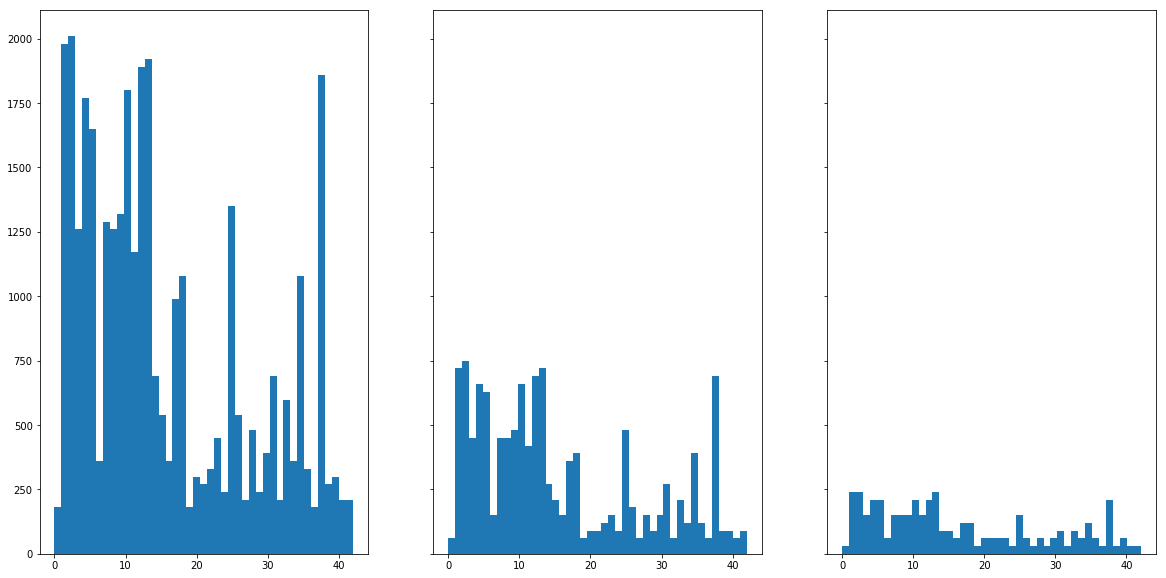

In [5]:
fig, axs = plt.subplots(1,3,figsize=(20,10),sharex=False, sharey=True)
axs[0].hist(y_train,bins=43)
axs[1].hist(y_test,bins=43)
axs[2].hist(y_valid,bins=43)

In [6]:
from random import randrange

def rotate():
    print("**************Calling rotate function")
    global X_train
    global y_train
    imgs = []
    length = int(len(X_train))
    print("************** shape = " ,X_train.shape)
    print("************** y shape = " ,y_train.shape)
    for i in range(length):
        #irand = randrange(0,n_train)
        img_30 = ndimage.rotate(X_train[i],30,reshape=False)    # the new pic doesnt reshape to fit the boundaries
        imgs.append(img_30)
        y_train = np.append(y_train,y_train[i])
    print("*************** 30 deg rotation finished")
    npa = np.asarray(imgs)
    X_train = np.concatenate((X_train,npa), axis=0)
    print("************** shape 2 = " ,X_train.shape)
    print("************** y shape 2= " ,y_train.shape)

    #X_train, y_train = shuffle(X_train, y_train)

    imgs = []
    for i in range(length):
        #irand = randrange(0,n_train)
        img_n30 = ndimage.rotate(X_train[i],-30,reshape=False)  # the new pic doesnt reshape to fit the boundaries
        imgs.append(img_n30)
        y_train = np.append(y_train,y_train[i])
    npa = np.asarray(imgs)
    X_train = np.concatenate((X_train,npa), axis=0)

    print("**************** -30 deg rotation finished")
    

#### Call rotate function for data augmentation

In [7]:
X_train = X_train_normalized
X_train, y_train = shuffle(X_train, y_train)
rotate()
print("************** shape 2 = " ,X_train.shape)

**************Calling rotate function
************** shape =  (34799, 32, 32, 1)
************** y shape =  (34799,)
*************** 30 deg rotation finished
************** shape 2 =  (69598, 32, 32, 1)
************** y shape 2=  (69598,)
**************** -30 deg rotation finished
************** shape 2 =  (104397, 32, 32, 1)


#### Visualize rotated images

34799
69598


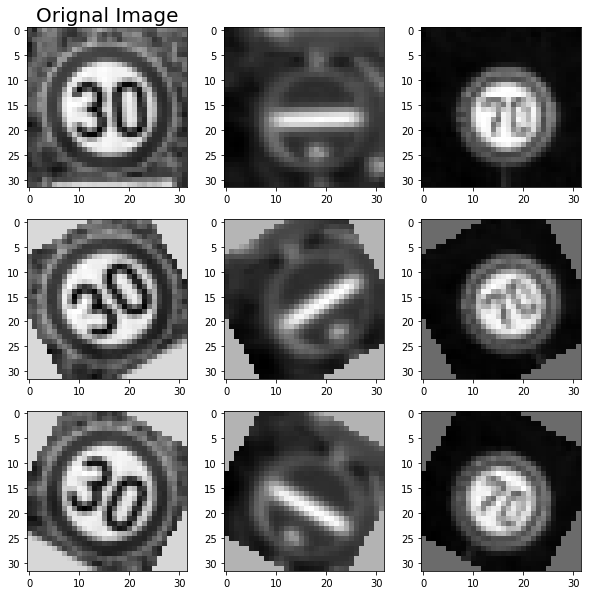

In [8]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
axs[0][0].set_title('Orignal Image', fontsize=20)
axs[0][0].imshow(X_train[1].squeeze() , cmap='gray')
axs[1][0].imshow(X_train[n_train + 1].squeeze() , cmap='gray')
axs[2][0].imshow(X_train[2*n_train + 1].squeeze() , cmap='gray')
axs[0][1].imshow(X_train[200].squeeze() , cmap='gray')
axs[1][1].imshow(X_train[n_train + 200].squeeze() , cmap='gray')
axs[2][1].imshow(X_train[2*n_train + 200].squeeze() , cmap='gray')
axs[0][2].imshow(X_train[400].squeeze() , cmap='gray')
axs[1][2].imshow(X_train[n_train + 400].squeeze() , cmap='gray')
axs[2][2].imshow(X_train[2*n_train + 400].squeeze() , cmap='gray')
print(n_train)
print(2*n_train)

#### Shuffle the images again

In [9]:
X_train, y_train = shuffle(X_train, y_train)

In [10]:
def warp():
    print("**************Calling warp function")
    more_X_train = []
    more_Y_train = []
    global X_train
    global y_train
    length = int(len(X_train)/5)
    for i in range(length):
        irand = randrange(0,n_train)
        dx, dy = np.random.randint(-1.7, 1.8, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        dst = cv2.warpAffine(X_train[irand], M, (X_train[irand].shape[0], X_train[irand].shape[1]))
        dst = dst[:,:,None]
        more_X_train.append(dst)
        more_Y_train.append(y_train[irand])

    more_X_train = np.array(more_X_train)
    more_Y_train = np.array(more_Y_train)
    print(more_X_train[0].shape)
    print(X_train[0].shape)
    X_train = np.concatenate((X_train, more_X_train), axis=0)
    y_train = np.concatenate((y_train, more_Y_train), axis=0)

**************Calling warp function
(32, 32, 1)
(32, 32, 1)


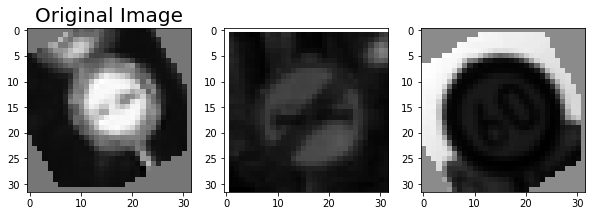

In [11]:
warp()

fig, axs = plt.subplots(1,3,figsize=(10,10))
axs[0].set_title('Original Image', fontsize=20)
axs[0].imshow(X_train[len(X_train) - 1].squeeze() , cmap='gray')
axs[1].imshow(X_train[len(X_train) - 2].squeeze() , cmap='gray')
axs[2].imshow(X_train[len(X_train) - 3].squeeze() , cmap='gray')

X_train, y_train = shuffle(X_train, y_train)

In [12]:
def sharpen():
    print("**************Calling rotate function")
    global X_train
    global y_train
    imgs = []
    length = int(len(X_train)/5)
    alpha = 30

    for i in range(length):
        irand = randrange(0,n_train)
        blurred_f  = ndimage.gaussian_filter(X_train[irand], 3)
        filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
        img_sharp = blurred_f + alpha * (blurred_f - filter_blurred_f)
        imgs.append(img_sharp)
        y_train = np.append(y_train,y_train[irand])
    print("*************** shapening finished")
    npa = np.asarray(imgs)
    X_train = np.concatenate((X_train,npa), axis=0)

#sharpen()
#X_train, y_train = shuffle(X_train, y_train)

In [13]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def call_brightness():
    global X_train
    global y_train
    length = int(len(X_train)/5)
    imgs = []
    for i in range(length):
        irand = randrange(0,n_train)
        if(i%100 == 0):
            print("completed ",(i/100 - 100 + 1), " percent" )
        frame = increase_brightness(X_train[irand],20)
        imgs.append(frame)
        y_train = np.append(y_train,y_train[irand])

    npa = np.asarray(imgs)
    X_train = np.concatenate((X_train,npa), axis=0)

#call_brightness()
#X_train, y_train = shuffle(X_train, y_train)

In [14]:
n_train = len(X_train)
num_channels = X_train.shape[3]
print("****************************************")
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("****************************************")

****************************************
Number of training examples = 125276
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
****************************************


In [15]:
def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    dropout = 0.50  # Dropout, probability to keep units

    # Layer 1: Convolution. Input = 32x32xnum_channels Output = 28x28x6
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,num_channels,6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling - 28x28x6 to 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')


    # Layer 2: Convolution.  Output = 10x10x6
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b

    # Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling - 10x10x16 to 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # Flatten - 5x5x16, Output = 400
    fc0 = flatten(conv2)

    #Layer 3 - Fully connected . Input = 400, output = 120
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b

    # Activation
    fc1 = tf.nn.relu(fc1)

    #Layer 4 - Fully connected . Input = 120, output = 84
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b

    # Activation
    fc2 = tf.nn.relu(fc2)

    #Layer 5 - Fully connected . Input = 84, output = 43
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_w) + fc3_b


    return logits

In [16]:
X_valid = X_valid_normalized
X_test = X_test_normalized
print(len(X_valid), len(X_test))

4410 12630


In [17]:
# placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, num_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Training Pipeline

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [18]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected,
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.793

EPOCH 2 ...
Validation Accuracy = 0.862

EPOCH 3 ...
Validation Accuracy = 0.879

EPOCH 4 ...
Validation Accuracy = 0.881

EPOCH 5 ...
Validation Accuracy = 0.889

EPOCH 6 ...
Validation Accuracy = 0.897

EPOCH 7 ...
Validation Accuracy = 0.892

EPOCH 8 ...
Validation Accuracy = 0.899

EPOCH 9 ...
Validation Accuracy = 0.897

EPOCH 10 ...
Validation Accuracy = 0.890

EPOCH 11 ...
Validation Accuracy = 0.903

EPOCH 12 ...
Validation Accuracy = 0.908

EPOCH 13 ...
Validation Accuracy = 0.904

EPOCH 14 ...
Validation Accuracy = 0.907

EPOCH 15 ...
Validation Accuracy = 0.917

EPOCH 16 ...
Validation Accuracy = 0.912

EPOCH 17 ...
Validation Accuracy = 0.913

EPOCH 18 ...
Validation Accuracy = 0.923

EPOCH 19 ...
Validation Accuracy = 0.911

EPOCH 20 ...
Validation Accuracy = 0.915

EPOCH 21 ...
Validation Accuracy = 0.908

EPOCH 22 ...
Validation Accuracy = 0.920

EPOCH 23 ...
Validation Accuracy = 0.917

EPOCH 24 ...
Validation Accura

In [20]:
print(len(X_train))
print(len(X_valid))
print(len(X_test))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Valid Accuracy = {:.3f}".format(valid_accuracy))    
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

125276
4410
12630
INFO:tensorflow:Restoring parameters from ./lenet
Train Accuracy = 0.997
Valid Accuracy = 0.934
Test Accuracy = 0.918


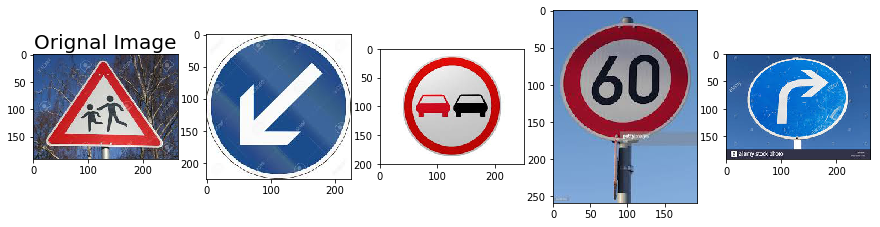

In [21]:
import matplotlib.image as mpimg
import glob

new_images = sorted(glob.glob('./new_signs/*.jpg'))
new_labels = np.array([28, 39, 9, 3, 33])
new_signs = []

fig, axs = plt.subplots(1,5,figsize=(15,15))
axs[0].set_title('Orignal Image', fontsize=20)
for i in range(len(new_images)):
    img = cv2.cvtColor(cv2.imread(new_images[i]), cv2.COLOR_BGR2RGB)
    new_signs.append(img)
    axs[i].imshow(img)

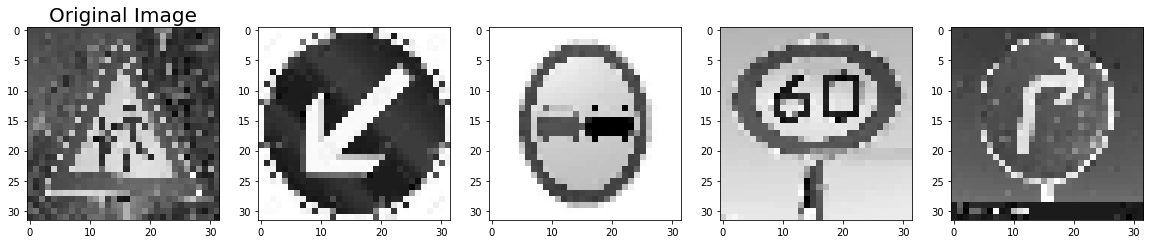

In [22]:
from PIL import Image

size = 32,32

np_im = []
arr = np.empty((0,32,32,3), int)
for i in range(len(new_images)):
    im = Image.open(new_images[i])
    im = im.resize(size)
    im = np.array(im)
#     print(np.shape(arr))
    np_im.append(np.array(im))
    arr = np.append(arr, np.array([im]), axis=0)

np_im = np.asarray(new_signs)
# print(np.shape(arr))

new_signs_gray = np.sum(arr/3, axis=3, keepdims=True)
new_signs_normalized = (new_signs_gray - np.float32(128))/np.float32(128)
    
fig, axs = plt.subplots(1,5,figsize=(20,20))
axs[0].set_title('Original Image', fontsize=20)
for i in range(5):
    axs[i].imshow(new_signs_normalized[i].squeeze() , cmap='gray')

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
#     saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_accuracy = evaluate(new_signs_normalized, new_labels)
    print("My Data Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
My Data Set Accuracy = 0.600
